# Projektas

## Modulių importavimas ir bendros parinktys

In [1]:
from pyspark import ml
from pyspark import mllib
from pyspark.mllib.stat import Statistics
import pyspark.ml.feature
import pyspark.ml.clustering
import pyspark.ml.classification
import pyspark.ml.evaluation
import pyspark.mllib.feature
import pyspark.mllib.clustering
import ggplot as gg
import pandas as pd
import os

import numpy as np

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.mllib.linalg import DenseVector, Vectors

def ensureDenseFeatures(featurizedDF, featuresCol="features"):
    columns = featurizedDF.columns
    idxCol = columns.index(featuresCol)
    transformedRow = pyspark.sql.Row(*columns)
    
    def rowColumnSparseToDense(row):
        values = list(row)
        values[idxCol] = pyspark.mllib.linalg.DenseVector(row[idxCol].toArray())
        return transformedRow(*values)
    
    featurizedDF = featurizedDF.rdd.map(rowColumnSparseToDense).toDF()
    
    return featurizedDF

def predictKMeans(x, centers):
    return min(
        (i for i in range(len(centers))), 
        key=lambda i: (x - centers[i]).norm(2))

def addKMeansPredictionToRow(row, featuresCol, kMeansModelCenters):
    features = row.asDict()[featuresCol]
    return row + (predictKMeans(features, kMeansModelCenters),)

def addKMeansPredictionToDataFrame(df, featuresCol, predictionCol, kMeansModelCenters):
    return (
        df.rdd
        .map(lambda r: addKMeansPredictionToRow(r, featuresCol, kMeansModelCenters))
        .toDF(df.columns + [predictionCol])
    )

Grafikų braižymui notebook'e:

In [2]:
%matplotlib inline

## Duomenų įkėlimas

Patikriname ar `pySpark` branduoklys sėkmingai įkeltas, t.y. ar aplinkoje egzistuoja `sqlContext` objektas:

In [3]:
sqlContext

Mūsų darbinė direktorija:

In [4]:
! pwd

/home/vagrant/synced_dir


In [ ]:
! tree -L 2

Prieš įkeliant duomenis patikriname jų formatą.

In [6]:
! head -n 2 00015/customer_usage_00015.csv

year,month,user_account_id,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,user_use_gprs,user_does_reload,reloads_inactive_days,reloads_count,reloads_sum,calls_outgoing_count,calls_outgoing_spendings,calls_outgoing_duration,calls_outgoing_spendings_max,calls_outgoing_duration_max,calls_outgoing_inactive_days,calls_outgoing_to_onnet_count,calls_outgoing_to_onnet_spendings,calls_outgoing_to_onnet_duration,calls_outgoing_to_onnet_inactive_days,calls_outgoing_to_offnet_count,calls_outgoing_to_offnet_spendings,calls_outgoing_to_offnet_duration,calls_outgoing_to_offnet_inactive_days,calls_outgoing_to_abroad_count,calls_outgoing_to_abroad_spendings,calls_outgoing_to_abroad_duration,calls_outgoing_to_abroad_inactive_days,sms_outgoing_count,sms_outgoing_spendings,sms_outgoing_spendings_max,sms_outgoing_inactive_days,sms_outgoing_to_onnet_count,sms_outgoing_to_onnet_spendings,sms_outgoing_to_onnet_

In [7]:
! head -n 2 00015/customer_churners_00015.csv

year,month,user_account_id,churn
2016,9,1151965,0


Duomenų nuskaitymas naudojant spark-csv Apache Spark

In [8]:
pathDataset = '00015/customer_usage_00015.csv'

bankDf = (
    sqlContext.read.format('com.databricks.spark.csv')
    .options(header='true', inferschema='true', delimiter=",")
    .load(pathDataset)
)


In [9]:
pathDataset = '00015/customer_churners_00015.csv'

churnersDf = (
    sqlContext.read.format('com.databricks.spark.csv')
    .options(header='true', inferschema='true', delimiter=",")
    .load(pathDataset)
)

In [10]:
bankDf.columns

['year',
 'month',
 'user_account_id',
 'user_lifetime',
 'user_intake',
 'user_no_outgoing_activity_in_days',
 'user_account_balance_last',
 'user_spendings',
 'user_has_outgoing_calls',
 'user_has_outgoing_sms',
 'user_use_gprs',
 'user_does_reload',
 'reloads_inactive_days',
 'reloads_count',
 'reloads_sum',
 'calls_outgoing_count',
 'calls_outgoing_spendings',
 'calls_outgoing_duration',
 'calls_outgoing_spendings_max',
 'calls_outgoing_duration_max',
 'calls_outgoing_inactive_days',
 'calls_outgoing_to_onnet_count',
 'calls_outgoing_to_onnet_spendings',
 'calls_outgoing_to_onnet_duration',
 'calls_outgoing_to_onnet_inactive_days',
 'calls_outgoing_to_offnet_count',
 'calls_outgoing_to_offnet_spendings',
 'calls_outgoing_to_offnet_duration',
 'calls_outgoing_to_offnet_inactive_days',
 'calls_outgoing_to_abroad_count',
 'calls_outgoing_to_abroad_spendings',
 'calls_outgoing_to_abroad_duration',
 'calls_outgoing_to_abroad_inactive_days',
 'sms_outgoing_count',
 'sms_outgoing_spending

In [11]:
churnersDf.columns

['year', 'month', 'user_account_id', 'churn']

In [12]:
summaryDf = bankDf.describe()
summaryDf

DataFrame[summary: string, year: string, month: string, user_account_id: string, user_lifetime: string, user_intake: string, user_no_outgoing_activity_in_days: string, user_account_balance_last: string, user_spendings: string, user_has_outgoing_calls: string, user_has_outgoing_sms: string, user_use_gprs: string, user_does_reload: string, reloads_inactive_days: string, reloads_count: string, reloads_sum: string, calls_outgoing_count: string, calls_outgoing_spendings: string, calls_outgoing_duration: string, calls_outgoing_spendings_max: string, calls_outgoing_duration_max: string, calls_outgoing_inactive_days: string, calls_outgoing_to_onnet_count: string, calls_outgoing_to_onnet_spendings: string, calls_outgoing_to_onnet_duration: string, calls_outgoing_to_onnet_inactive_days: string, calls_outgoing_to_offnet_count: string, calls_outgoing_to_offnet_spendings: string, calls_outgoing_to_offnet_duration: string, calls_outgoing_to_offnet_inactive_days: string, calls_outgoing_to_abroad_coun

In [13]:
churnersSummaryDf = churnersDf.describe()
churnersSummaryDf

DataFrame[summary: string, year: string, month: string, user_account_id: string, churn: string]

In [14]:
summaryDf.toPandas().T

0                     1  \
summary                                      count                  mean   
year                                        118543                2016.0   
month                                       118543     7.048497169803363   
user_account_id                             118543      541603.071450866   
user_lifetime                               118543     2820.953527411994   
user_intake                                 118543  0.025754367613439848   
user_no_outgoing_activity_in_days           118543    45.195895160405925   
user_account_balance_last                   118543     10.49116835241253   
user_spendings                              118543     7.109467366272053   
user_has_outgoing_calls                     118543    0.8817728587938554   
user_has_outgoing_sms                       118543    0.6576179108003003   
user_use_gprs                               118543   0.05044582978328539   
user_does_reload                            118543   0.49022717494917456   
reloads_inactive_days                       118543    400.62627063597176   
reloads_count                               118543    0.8576718996482289   
reloads_sum                                 118543     7.486300835984286   
calls_outgoing_count                        118543     37.08912377786963   
calls_outgoing_spendings                    118543    4.8963026918500985   
calls_outgoing_duration                     118543     33.20546080325299   
calls_outgoing_spendings_max                118543    0.9189314425989725   
calls_outgoing_duration_max                 118543     5.010782416507058   
calls_outgoing_inactive_days                118543    101.53229629754604   
calls_outgoing_to_onnet_count               118543   0.47746387386855405   
calls_outgoing_to_onnet_spendings           118543     0.206182229233273   
calls_outgoing_to_onnet_duration            118543    0.6181116556861226   
calls_outgoing_to_onnet_inactive_days       118543    101.53229629754604   
calls_outgoing_to_offnet_count              118543     16.30560218654834   
calls_outgoing_to_offnet_spendings          118543     2.918942156010745   
calls_outgoing_to_offnet_duration           118543     21.22548214571932   
calls_outgoing_to_offnet_inactive_days      118543    101.53229629754604   
...                                            ...                   ...   
sms_outgoing_spendings_max                  118543   0.09427929105896633   
sms_outgoing_inactive_days                  118543     332.4020397661608   
sms_outgoing_to_onnet_count                 118543     2.733801236682048   
sms_outgoing_to_onnet_spendings             118543   0.12051601528559638   
sms_outgoing_to_onnet_inactive_days         118543     332.4020397661608   
sms_outgoing_to_offnet_count                118543    22.946416068430864   
sms_outgoing_to_offnet_spendings            118543    1.3377658739865963   
sms_outgoing_to_offnet_inactive_days        118543     332.4020397661608   
sms_outgoing_to_abroad_count                118543    1.7829901385994955   
sms_outgoing_to_abroad_spendings            118543   0.18964316745822943   
sms_outgoing_to_abroad_inactive_days        118543     332.4020397661608   
sms_incoming_count                          118543     9.626726166876155   
sms_incoming_spendings                      118543   0.13432982124630213   
sms_incoming_from_abroad_count              118543     1.410973233341488   
sms_incoming_from_abroad_spendings          118543  0.013770614882363275   
gprs_session_count                          118543    10.599925765334099   
gprs_usage                                  118543     3.366226685675233   
gprs_spendings                              118543   0.20548585745256953   
gprs_inactive_days                          118543    1198.8669934116733   
last_100_reloads_count                      118543     3.682798646904499   
last_100_reloads_sum                        118543     23.15095168841655   
last_100_calls_outgoi

In [15]:
churnersSummaryDf.toPandas().T

0                    1                    2     3  \
summary          count                 mean               stddev   min   
year             43223               2016.0                  0.0  2016   
month            43223                  9.0                  0.0     9   
user_account_id  43223    597233.2819563658     429500.625640146    36   
churn            43223  0.21111445295328876  0.40810414596866085     0   

                       4  
summary              max  
year                2016  
month                  9  
user_account_id  1196936  
churn                  1

## AGREGAVIMAS

In [16]:
bankDf.registerTempTable("customer_usage")

In [17]:
dateCols = ["year", "month"]
idCols = ["user_account_id"]
binaryCols = [
    "user_intake",
    "user_has_outgoing_calls", "user_has_outgoing_sms", 
    "user_use_gprs", "user_does_reload"
]

In [18]:
categoricalCols = dateCols + binaryCols + idCols

continuousCols = [c for c in bankDf.columns if c not in categoricalCols]

In [19]:
sqlExprsMeanCols = ["AVG({0}) AS {0}".format(c) for c in continuousCols]
sqlExprsMeanCols

['AVG(user_lifetime) AS user_lifetime',
 'AVG(user_no_outgoing_activity_in_days) AS user_no_outgoing_activity_in_days',
 'AVG(user_account_balance_last) AS user_account_balance_last',
 'AVG(user_spendings) AS user_spendings',
 'AVG(reloads_inactive_days) AS reloads_inactive_days',
 'AVG(reloads_count) AS reloads_count',
 'AVG(reloads_sum) AS reloads_sum',
 'AVG(calls_outgoing_count) AS calls_outgoing_count',
 'AVG(calls_outgoing_spendings) AS calls_outgoing_spendings',
 'AVG(calls_outgoing_duration) AS calls_outgoing_duration',
 'AVG(calls_outgoing_spendings_max) AS calls_outgoing_spendings_max',
 'AVG(calls_outgoing_duration_max) AS calls_outgoing_duration_max',
 'AVG(calls_outgoing_inactive_days) AS calls_outgoing_inactive_days',
 'AVG(calls_outgoing_to_onnet_count) AS calls_outgoing_to_onnet_count',
 'AVG(calls_outgoing_to_onnet_spendings) AS calls_outgoing_to_onnet_spendings',
 'AVG(calls_outgoing_to_onnet_duration) AS calls_outgoing_to_onnet_duration',
 'AVG(calls_outgoing_to_onne

In [20]:
sqlExprsBinaryCols = ["MAX({0}) AS {0}".format(c) for c in binaryCols]
sqlExprsBinaryCols

['MAX(user_intake) AS user_intake',
 'MAX(user_has_outgoing_calls) AS user_has_outgoing_calls',
 'MAX(user_has_outgoing_sms) AS user_has_outgoing_sms',
 'MAX(user_use_gprs) AS user_use_gprs',
 'MAX(user_does_reload) AS user_does_reload']

In [21]:
sqlExprsDateCols = ["COUNT(*) AS n_months"]
sqlExprsDateCols

['COUNT(*) AS n_months']

In [22]:
sqlSelectExprs = sqlExprsMeanCols + sqlExprsBinaryCols + sqlExprsDateCols
sqlSelectExprs

['AVG(user_lifetime) AS user_lifetime',
 'AVG(user_no_outgoing_activity_in_days) AS user_no_outgoing_activity_in_days',
 'AVG(user_account_balance_last) AS user_account_balance_last',
 'AVG(user_spendings) AS user_spendings',
 'AVG(reloads_inactive_days) AS reloads_inactive_days',
 'AVG(reloads_count) AS reloads_count',
 'AVG(reloads_sum) AS reloads_sum',
 'AVG(calls_outgoing_count) AS calls_outgoing_count',
 'AVG(calls_outgoing_spendings) AS calls_outgoing_spendings',
 'AVG(calls_outgoing_duration) AS calls_outgoing_duration',
 'AVG(calls_outgoing_spendings_max) AS calls_outgoing_spendings_max',
 'AVG(calls_outgoing_duration_max) AS calls_outgoing_duration_max',
 'AVG(calls_outgoing_inactive_days) AS calls_outgoing_inactive_days',
 'AVG(calls_outgoing_to_onnet_count) AS calls_outgoing_to_onnet_count',
 'AVG(calls_outgoing_to_onnet_spendings) AS calls_outgoing_to_onnet_spendings',
 'AVG(calls_outgoing_to_onnet_duration) AS calls_outgoing_to_onnet_duration',
 'AVG(calls_outgoing_to_onne

In [23]:
sqlSelect = ", ".join(sqlSelectExprs)
sqlSelect

'AVG(user_lifetime) AS user_lifetime, AVG(user_no_outgoing_activity_in_days) AS user_no_outgoing_activity_in_days, AVG(user_account_balance_last) AS user_account_balance_last, AVG(user_spendings) AS user_spendings, AVG(reloads_inactive_days) AS reloads_inactive_days, AVG(reloads_count) AS reloads_count, AVG(reloads_sum) AS reloads_sum, AVG(calls_outgoing_count) AS calls_outgoing_count, AVG(calls_outgoing_spendings) AS calls_outgoing_spendings, AVG(calls_outgoing_duration) AS calls_outgoing_duration, AVG(calls_outgoing_spendings_max) AS calls_outgoing_spendings_max, AVG(calls_outgoing_duration_max) AS calls_outgoing_duration_max, AVG(calls_outgoing_inactive_days) AS calls_outgoing_inactive_days, AVG(calls_outgoing_to_onnet_count) AS calls_outgoing_to_onnet_count, AVG(calls_outgoing_to_onnet_spendings) AS calls_outgoing_to_onnet_spendings, AVG(calls_outgoing_to_onnet_duration) AS calls_outgoing_to_onnet_duration, AVG(calls_outgoing_to_onnet_inactive_days) AS calls_outgoing_to_onnet_inact

In [24]:
aggregatedUsageDf = sqlContext.sql("""
    SELECT user_account_id, {}
    FROM customer_usage
    GROUP BY user_account_id
""".format(sqlSelect))

In [25]:
aggregatedUsageDf.first()

Row(user_account_id=1031, user_lifetime=947.0, user_no_outgoing_activity_in_days=0.3333333333333333, user_account_balance_last=10.993333333333334, user_spendings=10.3, reloads_inactive_days=12.0, reloads_count=1.3333333333333333, reloads_sum=10.013333333333334, calls_outgoing_count=83.66666666666667, calls_outgoing_spendings=5.859999999999999, calls_outgoing_duration=55.69, calls_outgoing_spendings_max=0.5966666666666667, calls_outgoing_duration_max=10.333333333333334, calls_outgoing_inactive_days=0.6666666666666666, calls_outgoing_to_onnet_count=0.0, calls_outgoing_to_onnet_spendings=0.0, calls_outgoing_to_onnet_duration=0.0, calls_outgoing_to_onnet_inactive_days=0.6666666666666666, calls_outgoing_to_offnet_count=23.333333333333332, calls_outgoing_to_offnet_spendings=2.8833333333333333, calls_outgoing_to_offnet_duration=25.0, calls_outgoing_to_offnet_inactive_days=0.6666666666666666, calls_outgoing_to_abroad_count=0.0, calls_outgoing_to_abroad_spendings=0.0, calls_outgoing_to_abroad_d

## Požymių (angl. _features_) sudarymas klasterizavimui

In [26]:
assembler = VectorAssembler(inputCols=continuousCols, outputCol="features")

In [27]:
featurizedDF = assembler.transform(aggregatedUsageDf)

In [28]:
scaler = StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="scaled_features")

In [29]:
featuresEnsuredDF = ensureDenseFeatures(featurizedDF)

In [30]:
featuresEnsuredDF.first()

Row(user_account_id=1031, user_lifetime=947.0, user_no_outgoing_activity_in_days=0.3333333333333333, user_account_balance_last=10.993333333333334, user_spendings=10.3, reloads_inactive_days=12.0, reloads_count=1.3333333333333333, reloads_sum=10.013333333333334, calls_outgoing_count=83.66666666666667, calls_outgoing_spendings=5.859999999999999, calls_outgoing_duration=55.69, calls_outgoing_spendings_max=0.5966666666666667, calls_outgoing_duration_max=10.333333333333334, calls_outgoing_inactive_days=0.6666666666666666, calls_outgoing_to_onnet_count=0.0, calls_outgoing_to_onnet_spendings=0.0, calls_outgoing_to_onnet_duration=0.0, calls_outgoing_to_onnet_inactive_days=0.6666666666666666, calls_outgoing_to_offnet_count=23.333333333333332, calls_outgoing_to_offnet_spendings=2.8833333333333333, calls_outgoing_to_offnet_duration=25.0, calls_outgoing_to_offnet_inactive_days=0.6666666666666666, calls_outgoing_to_abroad_count=0.0, calls_outgoing_to_abroad_spendings=0.0, calls_outgoing_to_abroad_d

In [31]:
scalerModelEnsured = scaler.fit(featuresEnsuredDF)

In [32]:
featurizedScaledEnsuredDF = scalerModelEnsured.transform(featuresEnsuredDF)

In [33]:
featurizedScaledEnsuredDF.take(5)

[Row(user_account_id=1031, user_lifetime=947.0, user_no_outgoing_activity_in_days=0.3333333333333333, user_account_balance_last=10.993333333333334, user_spendings=10.3, reloads_inactive_days=12.0, reloads_count=1.3333333333333333, reloads_sum=10.013333333333334, calls_outgoing_count=83.66666666666667, calls_outgoing_spendings=5.859999999999999, calls_outgoing_duration=55.69, calls_outgoing_spendings_max=0.5966666666666667, calls_outgoing_duration_max=10.333333333333334, calls_outgoing_inactive_days=0.6666666666666666, calls_outgoing_to_onnet_count=0.0, calls_outgoing_to_onnet_spendings=0.0, calls_outgoing_to_onnet_duration=0.0, calls_outgoing_to_onnet_inactive_days=0.6666666666666666, calls_outgoing_to_offnet_count=23.333333333333332, calls_outgoing_to_offnet_spendings=2.8833333333333333, calls_outgoing_to_offnet_duration=25.0, calls_outgoing_to_offnet_inactive_days=0.6666666666666666, calls_outgoing_to_abroad_count=0.0, calls_outgoing_to_abroad_spendings=0.0, calls_outgoing_to_abroad_

In [34]:
featurizedScaledEnsuredDF.columns

['user_account_id',
 'user_lifetime',
 'user_no_outgoing_activity_in_days',
 'user_account_balance_last',
 'user_spendings',
 'reloads_inactive_days',
 'reloads_count',
 'reloads_sum',
 'calls_outgoing_count',
 'calls_outgoing_spendings',
 'calls_outgoing_duration',
 'calls_outgoing_spendings_max',
 'calls_outgoing_duration_max',
 'calls_outgoing_inactive_days',
 'calls_outgoing_to_onnet_count',
 'calls_outgoing_to_onnet_spendings',
 'calls_outgoing_to_onnet_duration',
 'calls_outgoing_to_onnet_inactive_days',
 'calls_outgoing_to_offnet_count',
 'calls_outgoing_to_offnet_spendings',
 'calls_outgoing_to_offnet_duration',
 'calls_outgoing_to_offnet_inactive_days',
 'calls_outgoing_to_abroad_count',
 'calls_outgoing_to_abroad_spendings',
 'calls_outgoing_to_abroad_duration',
 'calls_outgoing_to_abroad_inactive_days',
 'sms_outgoing_count',
 'sms_outgoing_spendings',
 'sms_outgoing_spendings_max',
 'sms_outgoing_inactive_days',
 'sms_outgoing_to_onnet_count',
 'sms_outgoing_to_onnet_spendi

## Klasterizavimas

### K-vidurkių modelis naudojant `pyspark.mllib.clustering.KMeans`

`pyspark.mllib` naudojami `RDD`, o ne `DataFrame` objektai, todėl sukuriame normalizuotų požymių `RDD`:

In [35]:
scaledFeaturesRdd = (
    featurizedScaledEnsuredDF.select("scaled_features").rdd 
    .map(lambda r: r[0])
)

Sudarome modelį su klasterių skaičiumi `k`:

In [36]:
k = 5
kmeansModelMllib = mllib.clustering.KMeans.train(scaledFeaturesRdd, k=k)

In [37]:
kmeansModelMllib.centers

[array([ 0.29546363,  0.04153358, -0.14180101, -0.46470496,  0.92825465,
        -0.51827575, -0.45946888, -0.41530465, -0.3873244 , -0.41132804,
        -0.41194588, -0.4925469 , -0.28995244, -0.18135237, -0.12501738,
        -0.12210887, -0.28995244, -0.36299203, -0.38997702, -0.3559796 ,
        -0.28995244, -0.1489188 , -0.14604239, -0.14514551, -0.28995244,
        -0.39185686, -0.34614591, -0.36712099,  1.29609672, -0.15493052,
        -0.20396114,  1.29609672, -0.33995226, -0.34168362,  1.29609672,
        -0.21558846, -0.20577926,  1.29609672, -0.51345557, -0.10931632,
        -0.29492378, -0.07558485, -0.06988895, -0.05868656, -0.07114683,
         0.25124994, -0.46374705, -0.44678238, -0.41484832, -0.12761473,
        -0.36559661, -0.14690782, -0.39409266, -0.18823577, -0.34395481,
        -0.2013298 , -0.07538153]),
 array([-0.43013998, -0.21836465,  0.10635411, -0.07667525, -0.16843844,
        -0.11075807, -0.07041197, -0.04356766, -0.09814483, -0.08914178,
         0.0118

In [38]:
mllibKmeansClusteredBankDf = addKMeansPredictionToDataFrame(
    featurizedScaledEnsuredDF, 
    "scaled_features", 
    "pred_kmeans_mllib", 
    kmeansModelMllib.centers)

In [39]:
ks = list(range(1, 10))

In [40]:
kMllibModelPairs = [
    (k, mllib.clustering.KMeans.train(scaledFeaturesRdd, k=k)) 
    for k in ks
]

In [41]:
kMllibCostPairs = [
    (k, model.computeCost(scaledFeaturesRdd)) 
    for k, model in kMllibModelPairs
]

In [42]:
kMllibCostPdDf = pd.DataFrame.from_records(
    kMllibCostPairs, 
    columns=["k", "cost"])

/home/vagrant/.miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


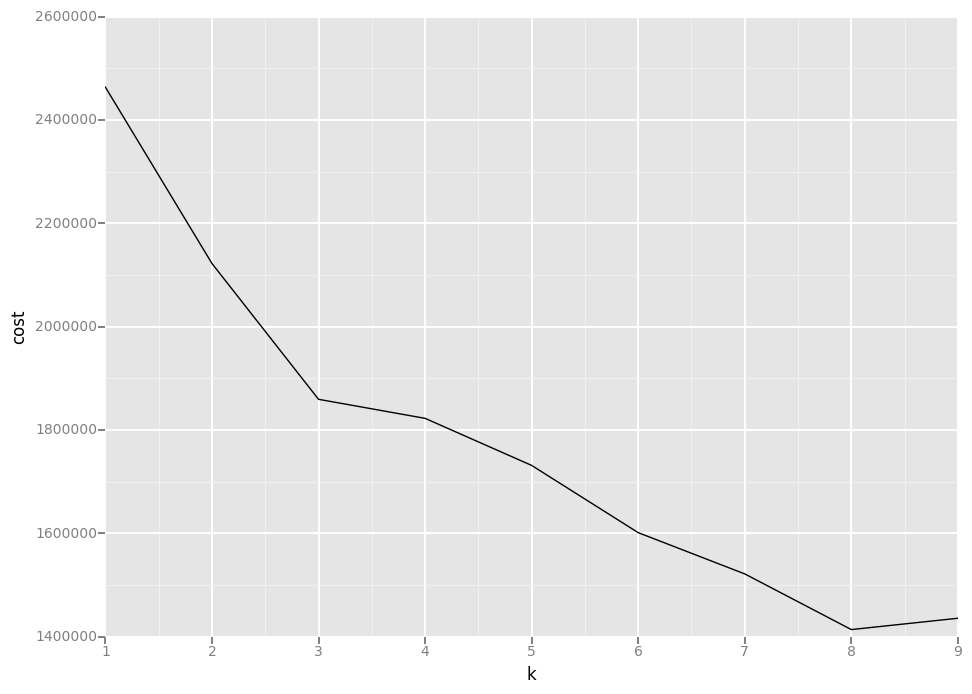

<ggplot: (-899482058)>

In [43]:
gg.ggplot(kMllibCostPdDf, gg.aes(x="k", y="cost")) + gg.geom_line()

## Klasifikavimas

### Apmokymo, validavimo ir testavimo imčių sudarymas ir požymių (angl. _features_) sudarymas klasifikavimui

Naudosime sprendimų medžio modelį, kuriam kintamųjų normalizuoti nebūtina ir kuriam tinka ne tik tolydžiojo tipo kintamieji.

In [44]:
responseColumns = ["churn"]

In [45]:
featuresEnsuredDF.registerTempTable("featuresEnsured")
churnersDf.registerTempTable("churners")

In [46]:
clasificationDf = sqlContext.sql("""
    SELECT a.*, b.churn
    FROM customer_usage a, churners b
    WHERE a.user_account_id = b.user_account_id
""")

clasificationDf.first()

Row(year=2016, month=6, user_account_id=1031, user_lifetime=916, user_intake=0, user_no_outgoing_activity_in_days=1, user_account_balance_last=9.81, user_spendings=10.83, user_has_outgoing_calls=1, user_has_outgoing_sms=1, user_use_gprs=0, user_does_reload=1, reloads_inactive_days=13, reloads_count=1, reloads_sum=6.0, calls_outgoing_count=65, calls_outgoing_spendings=6.03, calls_outgoing_duration=52.93, calls_outgoing_spendings_max=0.57, calls_outgoing_duration_max=9.0, calls_outgoing_inactive_days=1, calls_outgoing_to_onnet_count=0, calls_outgoing_to_onnet_spendings=0.0, calls_outgoing_to_onnet_duration=0.0, calls_outgoing_to_onnet_inactive_days=1, calls_outgoing_to_offnet_count=20, calls_outgoing_to_offnet_spendings=3.12, calls_outgoing_to_offnet_duration=26.0, calls_outgoing_to_offnet_inactive_days=1, calls_outgoing_to_abroad_count=0, calls_outgoing_to_abroad_spendings=0.0, calls_outgoing_to_abroad_duration=0.0, calls_outgoing_to_abroad_inactive_days=1, sms_outgoing_count=98, sms_ou

In [47]:
indexingStages = ([ml.feature.StringIndexer(inputCol="churn", outputCol="label_index")])

indexingStages

[StringIndexer_42c8973c64789c63336b]

In [48]:
indexingPipeline = ml.pipeline.Pipeline(stages=indexingStages)

In [49]:
classificationFeatureColumns = [c for c in clasificationDf.columns if c not in (responseColumns)]
classificationFeatureColumns

['year',
 'month',
 'user_account_id',
 'user_lifetime',
 'user_intake',
 'user_no_outgoing_activity_in_days',
 'user_account_balance_last',
 'user_spendings',
 'user_has_outgoing_calls',
 'user_has_outgoing_sms',
 'user_use_gprs',
 'user_does_reload',
 'reloads_inactive_days',
 'reloads_count',
 'reloads_sum',
 'calls_outgoing_count',
 'calls_outgoing_spendings',
 'calls_outgoing_duration',
 'calls_outgoing_spendings_max',
 'calls_outgoing_duration_max',
 'calls_outgoing_inactive_days',
 'calls_outgoing_to_onnet_count',
 'calls_outgoing_to_onnet_spendings',
 'calls_outgoing_to_onnet_duration',
 'calls_outgoing_to_onnet_inactive_days',
 'calls_outgoing_to_offnet_count',
 'calls_outgoing_to_offnet_spendings',
 'calls_outgoing_to_offnet_duration',
 'calls_outgoing_to_offnet_inactive_days',
 'calls_outgoing_to_abroad_count',
 'calls_outgoing_to_abroad_spendings',
 'calls_outgoing_to_abroad_duration',
 'calls_outgoing_to_abroad_inactive_days',
 'sms_outgoing_count',
 'sms_outgoing_spending

In [50]:
classificationAssembler = ml.feature.VectorAssembler(inputCols=classificationFeatureColumns, outputCol="features")

In [51]:
classificationFeaturizationPipeline = ml.pipeline.Pipeline(stages=[indexingPipeline, classificationAssembler])

In [52]:
classificationFeaturizationPipelineModel = classificationFeaturizationPipeline.fit(clasificationDf)

In [53]:
featurizedClassificationBankDf = classificationFeaturizationPipelineModel.transform(clasificationDf)

In [54]:
featurizedClassificationBankDf.select(["churn", "label_index"]).take(10)

[Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0),
 Row(churn=0, label_index=0.0)]

Kintamojo reikšmė ir indeksas sutampa.

In [55]:
trainingDf, validationDf, testDf = featurizedClassificationBankDf.randomSplit([0.5, 0.25, 0.25])

In [56]:
trainingDf.describe().toPandas().T

0                     1  \
summary                                     count                  mean   
year                                        59454                2016.0   
month                                       59454     7.051687018535338   
user_account_id                             59454     541108.4943990312   
user_lifetime                               59454    2826.2020721902645   
user_intake                                 59454  0.025734181047532546   
user_no_outgoing_activity_in_days           59454     44.93954990412756   
user_account_balance_last                   59454    10.441888687052176   
user_spendings                              59454     7.139035893295657   
user_has_outgoing_calls                     59454    0.8810845359437548   
user_has_outgoing_sms                       59454    0.6577353920678172   
user_use_gprs                               59454  0.051232885928617085   
user_does_reload                            59454   0.49370942241060317   
reloads_inactive_days                       59454    396.27732364517107   
reloads_count                               59454    0.8594711878090625   
reloads_sum                                 59454      7.54077185723416   
calls_outgoing_count                        59454     37.14681938978033   
calls_outgoing_spendings                    59454     4.903554008140748   
calls_outgoing_duration                     59454     33.17072678036803   
calls_outgoing_spendings_max                59454    0.9196402260571208   
calls_outgoing_duration_max                 59454     4.990129511891546   
calls_outgoing_inactive_days                59454    103.06521007837992   
calls_outgoing_to_onnet_count               59454   0.47006088740875296   
calls_outgoing_to_onnet_spendings           59454    0.2006694251017593   
calls_outgoing_to_onnet_duration            59454    0.5973932788374202   
calls_outgoing_to_onnet_inactive_days       59454    103.06521007837992   
calls_outgoing_to_offnet_count              59454    16.241531267870958   
calls_outgoing_to_offnet_spendings          59454     2.931410838631549   
calls_outgoing_to_offnet_duration           59454    21.259954923133854   
calls_outgoing_to_offnet_inactive_days      59454    103.06521007837992   
...                                           ...                   ...   
sms_outgoing_to_onnet_count                 59454     2.771722676354829   
sms_outgoing_to_onnet_spendings             59454   0.11869663941871023   
sms_outgoing_to_onnet_inactive_days         59454     331.1589632320786   
sms_outgoing_to_offnet_count                59454     23.12232986846974   
sms_outgoing_to_offnet_spendings            59454    1.3484902613785448   
sms_outgoing_to_offnet_inactive_days        59454     331.1589632320786   
sms_outgoing_to_abroad_count                59454    1.7384868974333099   
sms_outgoing_to_abroad_spendings            59454   0.18286069902781976   
sms_outgoing_to_abroad_inactive_days        59454     331.1589632320786   
sms_incoming_count                          59454     9.647458539374979   
sms_incoming_spendings                      59454   0.13313233760554377   
sms_incoming_from_abroad_count              59454    1.3983752144515087   
sms_incoming_from_abroad_spendings          59454  0.013353180610219671   
gprs_session_count                          59454    10.323813368318364   
gprs_usage                                  59454     3.249122010293673   
gprs_spendings                              59454    0.2091045177784506   
gprs_inactive_days                          59454    1198.5704746526726   
last_100_reloads_count                      59454     3.698439129410973   
last_100_reloads_sum                        59454    23.321564485148198   
last_100_calls_outgoing_duration            59454    104.33988276650861   
last_100_calls_outgoing_to_onnet_duration   59454     1.466679786053082   
last_100_calls_outgoing_to_offnet_duration  59454     68.89189776970426  

In [57]:
validationDf.describe().toPandas().T

0                     1  \
summary                                     count                  mean   
year                                        29569                2016.0   
month                                       29569      7.04717778754777   
user_account_id                             29569     543858.8299570496   
user_lifetime                               29569     2809.217694206771   
user_intake                                 29569  0.025127667489600596   
user_no_outgoing_activity_in_days           29569     45.28232270283067   
user_account_balance_last                   29569    10.609183604450605   
user_spendings                              29569     7.062539145726941   
user_has_outgoing_calls                     29569    0.8800094693767121   
user_has_outgoing_sms                       29569    0.6552808684771213   
user_use_gprs                               29569   0.05096553823260847   
user_does_reload                            29569    0.4871656126348541   
reloads_inactive_days                       29569     402.7721262132639   
reloads_count                               29569     0.854137779431161   
reloads_sum                                 29569     7.406520004058308   
calls_outgoing_count                        29569     37.11559403429267   
calls_outgoing_spendings                    29569    4.8685430687544375   
calls_outgoing_duration                     29569     32.95169907673577   
calls_outgoing_spendings_max                29569    0.9218776421251983   
calls_outgoing_duration_max                 29569     5.020954039703741   
calls_outgoing_inactive_days                29569    100.56166931583753   
calls_outgoing_to_onnet_count               29569   0.48530555649497786   
calls_outgoing_to_onnet_spendings           29569   0.21734451621630763   
calls_outgoing_to_onnet_duration            29569    0.6459176840610098   
calls_outgoing_to_onnet_inactive_days       29569    100.56166931583753   
calls_outgoing_to_offnet_count              29569    16.428793669045284   
calls_outgoing_to_offnet_spendings          29569     2.862963914910886   
calls_outgoing_to_offnet_duration           29569    20.791637525787145   
calls_outgoing_to_offnet_inactive_days      29569    100.56166931583753   
...                                           ...                   ...   
sms_outgoing_to_onnet_count                 29569    2.6412120802191486   
sms_outgoing_to_onnet_spendings             29569    0.1174077581250635   
sms_outgoing_to_onnet_inactive_days         29569    335.13453278771686   
sms_outgoing_to_offnet_count                29569    22.894720822483006   
sms_outgoing_to_offnet_spendings            29569    1.3348966823362303   
sms_outgoing_to_offnet_inactive_days        29569    335.13453278771686   
sms_outgoing_to_abroad_count                29569     1.775575771923298   
sms_outgoing_to_abroad_spendings            29569   0.19301836382698104   
sms_outgoing_to_abroad_inactive_days        29569    335.13453278771686   
sms_incoming_count                          29569     9.721059217423653   
sms_incoming_spendings                      29569   0.13119855253813115   
sms_incoming_from_abroad_count              29569    1.4580134600426122   
sms_incoming_from_abroad_spendings          29569   0.01364638641820825   
gprs_session_count                          29569     12.12729547837262   
gprs_usage                                  29569    3.8020386215293036   
gprs_spendings                              29569   0.21741080185329245   
gprs_inactive_days                          29569    1196.7770976360378   
last_100_reloads_count                      29569    3.6684027190638844   
last_100_reloads_sum                        29569    22.918336423281154   
last_100_calls_outgoing_duration            29569    103.73166187561297   
last_100_calls_outgoing_to_onnet_duration   29569    1.5215610943893956   
last_100_calls_outgoing_to_offnet_duration  29569     68.04210321620614  

In [58]:
testDf.describe().toPandas().T

0                     1  \
summary                                     count                  mean   
year                                        29520                2016.0   
month                                       29520     7.043394308943089   
user_account_id                             29520     540339.6588753387   
user_lifetime                               29520    2822.1381436314364   
user_intake                                 29520  0.026422764227642278   
user_no_outgoing_activity_in_days           29520     45.62560975609756   
user_account_balance_last                   29520    10.472207655826558   
user_spendings                              29520     7.096921747967476   
user_has_outgoing_calls                     29520    0.8849254742547426   
user_has_outgoing_sms                       29520    0.6597222222222222   
user_use_gprs                               29520   0.04834010840108401   
user_does_reload                            29520   0.48628048780487804   
reloads_inactive_days                       29520     407.2357384823848   
reloads_count                               29520    0.8575880758807588   
reloads_sum                                 29520     7.456508130081299   
calls_outgoing_count                        29520     36.94640921409214   
calls_outgoing_spendings                    29520     4.909504065040651   
calls_outgoing_duration                     29520     33.52959891598918   
calls_outgoing_spendings_max                29520    0.9145528455284555   
calls_outgoing_duration_max                 29520     5.042189363143633   
calls_outgoing_inactive_days                29520     99.41720867208672   
calls_outgoing_to_onnet_count               29520    0.4845189701897019   
calls_outgoing_to_onnet_spendings           29520    0.2061043360433603   
calls_outgoing_to_onnet_duration            29520    0.6319867886178857   
calls_outgoing_to_onnet_inactive_days       29520     99.41720867208672   
calls_outgoing_to_offnet_count              29520    16.311246612466125   
calls_outgoing_to_offnet_spendings          29520    2.9499010840108406   
calls_outgoing_to_offnet_duration           29520    21.590617886178848   
calls_outgoing_to_offnet_inactive_days      29520     99.41720867208672   
...                                           ...                   ...   
sms_outgoing_to_onnet_count                 29520     2.750169376693767   
sms_outgoing_to_onnet_spendings             29520   0.12729369918699185   
sms_outgoing_to_onnet_inactive_days         29520     332.1685975609756   
sms_outgoing_to_offnet_count                29520     22.64390243902439   
sms_outgoing_to_offnet_spendings            29520    1.3190406504065042   
sms_outgoing_to_offnet_inactive_days        29520     332.1685975609756   
sms_outgoing_to_abroad_count                29520    1.8800474254742547   
sms_outgoing_to_abroad_spendings            29520   0.19992242547425468   
sms_outgoing_to_abroad_inactive_days        29520     332.1685975609756   
sms_incoming_count                          29520     9.490481029810297   
sms_incoming_spendings                      29520   0.13987804878048773   
sms_incoming_from_abroad_count              29520    1.3892276422764227   
sms_incoming_from_abroad_spendings          29520  0.014735772357723574   
gprs_session_count                          29520     9.626117886178863   
gprs_usage                                  29520    3.1655430216802154   
gprs_spendings                              29520   0.18625304878048776   
gprs_inactive_days                          29520     1201.557554200542   
last_100_reloads_count                      29520     3.665718157181572   
last_100_reloads_sum                        29520     23.04033473577236   
last_100_calls_outgoing_duration            29520    104.46920630081297   
last_100_calls_outgoing_to_onnet_duration   29520    1.5082943766937669   
last_100_calls_outgoing_to_offnet_duration  29520     69.33959518970184  

### Hiper-parametrų derinimas

Sudarome keletą sprendimų medžio modelių su skirtingomis hiper-parametro maxDepth reikšmėmis.

In [59]:
dtDepht2 = ml.classification.DecisionTreeClassifier(
    maxDepth=2, labelCol="label_index", featuresCol="features")

In [60]:
dtDepht3 = ml.classification.DecisionTreeClassifier(
    maxDepth=3, labelCol="label_index", featuresCol="features")

In [61]:
dtDepht4 = ml.classification.DecisionTreeClassifier(
    maxDepth=4, labelCol="label_index", featuresCol="features")

In [62]:
dtDepht5 = ml.classification.DecisionTreeClassifier(
    maxDepth=5, labelCol="label_index", featuresCol="features")

Apmokome modelius su apmokymo imtimi.

In [63]:
dtDepht2Model = dtDepht2.fit(trainingDf)

In [64]:
dtDepht3Model = dtDepht3.fit(trainingDf)

In [65]:
dtDepht4Model = dtDepht4.fit(trainingDf)

In [66]:
dtDepht5Model = dtDepht5.fit(trainingDf)

In [67]:
dtDepht2ValidationDf = dtDepht2Model.transform(validationDf)

In [68]:
dtDepht3ValidationDf = dtDepht3Model.transform(validationDf)

In [69]:
dtDepht4ValidationDf = dtDepht4Model.transform(validationDf)

In [70]:
dtDepht5ValidationDf = dtDepht5Model.transform(validationDf)

#### Area Under ROC

In [71]:
auRocBinaryEvaluator = ml.evaluation.BinaryClassificationEvaluator(
    rawPredictionCol="rawPrediction", 
    labelCol="label_index",
    metricName="areaUnderROC")

In [72]:
auRocBinaryEvaluator.evaluate(dtDepht2ValidationDf)

0.6961294160713909

In [73]:
auRocBinaryEvaluator.evaluate(dtDepht3ValidationDf)

0.6860359885096802

In [74]:
auRocBinaryEvaluator.evaluate(dtDepht4ValidationDf)

0.6485733969776866

In [75]:
auRocBinaryEvaluator.evaluate(dtDepht5ValidationDf)

0.7021046715457175

#### Precision

In [76]:
multiPrecEvaluator = ml.evaluation.MulticlassClassificationEvaluator(
    predictionCol="prediction", 
    labelCol="label_index",
    metricName="precision")

In [77]:
multiPrecEvaluator.evaluate(dtDepht2ValidationDf)

0.8848456153403903

In [78]:
multiPrecEvaluator.evaluate(dtDepht3ValidationDf)

0.8848456153403903

In [79]:
multiPrecEvaluator.evaluate(dtDepht4ValidationDf)

0.885961649024316

In [80]:
multiPrecEvaluator.evaluate(dtDepht5ValidationDf)

0.8877540667591058

#### Recall

In [81]:
multiRecEvaluator = ml.evaluation.MulticlassClassificationEvaluator(
    predictionCol="prediction", 
    labelCol="label_index", 
    metricName="recall")

In [82]:
multiRecEvaluator.evaluate(dtDepht2ValidationDf)

0.8848456153403903

In [83]:
multiRecEvaluator.evaluate(dtDepht3ValidationDf)

0.8848456153403903

In [84]:
multiRecEvaluator.evaluate(dtDepht4ValidationDf)

0.885961649024316

In [85]:
multiRecEvaluator.evaluate(dtDepht5ValidationDf)

0.8877540667591058

#### F-measure

In [86]:
multiF1Evaluator = ml.evaluation.MulticlassClassificationEvaluator(
    predictionCol="prediction", 
    labelCol="label_index", 
    metricName="f1")

In [87]:
multiF1Evaluator.evaluate(dtDepht2ValidationDf)

0.8820148394504298

In [88]:
multiF1Evaluator.evaluate(dtDepht3ValidationDf)

0.8820148394504298

In [89]:
multiF1Evaluator.evaluate(dtDepht4ValidationDf)

0.878219812177749

In [90]:
multiF1Evaluator.evaluate(dtDepht5ValidationDf)

0.882637463898206

### Modelio paklaidų įvertinimas

In [91]:
dtDepht2TestDf = dtDepht2Model.transform(testDf)

In [92]:
dtDepht4TestDf = dtDepht4Model.transform(testDf)

In [93]:
dtDepht5TestDf = dtDepht5Model.transform(testDf)

#### Area under ROC

In [98]:
auRocBinaryEvaluator.evaluate(dtDepht5TestDf)

0.6937766993184259

#### Precision

In [99]:
multiPrecEvaluator.evaluate(dtDepht5TestDf)

0.8851964769647697

#### Recall

In [100]:
multiRecEvaluator.evaluate(dtDepht5TestDf)

0.8851964769647697

#### F-measure

In [101]:
multiF1Evaluator.evaluate(dtDepht5TestDf)

0.8801008698188708